# Solver comparison: Allen fit, 50 genes, no noise


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [2]:
# dataset_meta = ['allen_B08']
dataset_meta = ['allen_A01']
dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = './monod_demo_fits/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
def get_allen_meta(directory):
    allen_membership = pd.read_csv(directory+'/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(directory+'/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    return meta
meta_directory_v3 = '~/count_data/allen_metadata/sc'
meta_v3 = get_allen_meta(meta_directory_v3)


Dataset A01. 
	8145 barcodes in loom, 6443 pass filter. 6355 in annotations; of these, 6355 in loom and 5797 in filtered loom.


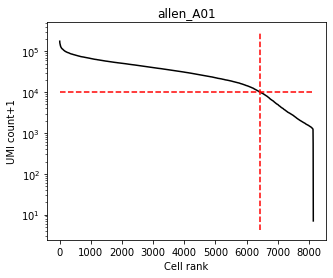

In [4]:
cf = []
thr_lb =  [1e4]
fig1,ax1 = plt.subplots(1,1,figsize=(5,4))

for k in range(len(dataset_meta)):
# for k in range(1):
    axloc = np.unravel_index(k,(2,4))
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k][-3:]
    
    meta = meta_v3
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        annot_bcs = meta[(meta['sample']==dataset_name)]['cell_barcode']
        cf.append(np.isin(bcs,annot_bcs) & cf_)

    ax1.set_title(raw_data_locations[k])


In [5]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [6]:
!mkdir -p monod_demo_fits

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1 already exists.
INFO:root:Dataset: allen_A01
INFO:root:5797 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7355 genes retained after expression filter.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01 already exists.
INFO:root:Total of 200 genes selected.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/diagnostic_figures already exists.


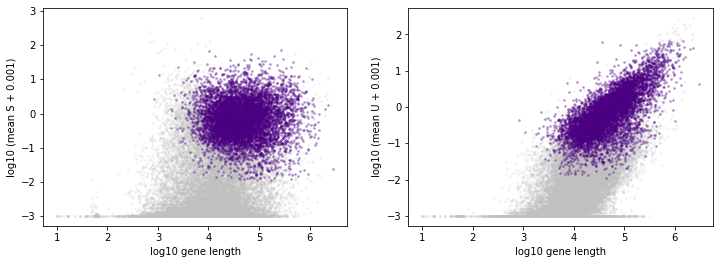

In [8]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./monod_demo_fits',meta='allen_noisefree',batch_id=1,\
                                             n_genes=200,exp_filter_threshold=None,cf=cf,creator='gccp',datestring='nodate')


In [9]:
print(dir_string)
print(dataset_strings)

./monod_demo_fits/gccp_nodate_026_allen_noisefree_1
['./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01']


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A01
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/genes.csv.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/diagnostic_figures already exists.
INFO:root:Search data stored to ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/raw.sd.
INFO:root:Search data loaded from ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/raw.sd.


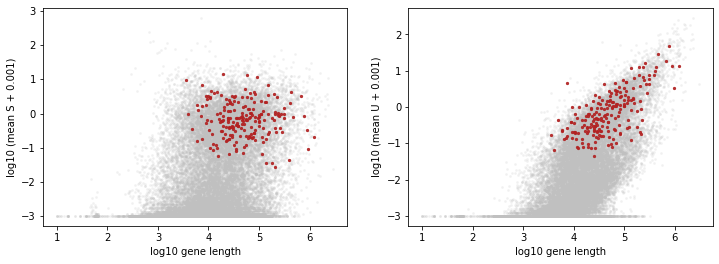

In [10]:
i = 0
_ = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
            dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])


In [56]:
search_data = monod.analysis.load_search_data(dataset_strings[0]+'/raw.sd')

INFO:root:Search data loaded from ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/raw.sd.


In [11]:
result_strings = []
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]

From the [previous notebook](https://github.com/pachterlab/GP_2021_3/blob/main/notebooks/noisefree_allen_fit.ipynb) running this dataset, we expect A01 to take a fairly short time.

In [87]:
i = 0
fitmodel_fq = monod.cme_toolbox.CMEModel('Bursty','None')
fitmodel_qv = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='quad_vec')
fitmodel_nn = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='nn')
fitmodel_nn10 = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='nn_10')

inference_parameters_fq = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_fq,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
inference_parameters_qv = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_qv,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
inference_parameters_nn = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_nn,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
inference_parameters_nn10 = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_nn10,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})


INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 already exists.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 already exists.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 already exists.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.
INFO

In [88]:
grad_inference_fq = monod.inference.GradientInference(inference_parameters_fq, fitmodel_fq, search_data, 0)
grad_inference_qv = monod.inference.GradientInference(inference_parameters_qv, fitmodel_qv, search_data, 0)
grad_inference_nn = monod.inference.GradientInference(inference_parameters_nn, fitmodel_nn, search_data, 0)
grad_inference_nn10 = monod.inference.GradientInference(inference_parameters_nn10, fitmodel_nn, search_data, 0)

In [18]:
import time

In [19]:
N=100

In [21]:
t_fq = []
res_fq = []
for i in range(N):
    t1 = time.time()
    res_fq.append(grad_inference_fq.optimize_gene(i,fitmodel_fq,search_data))
    t_fq.append(time.time()-t1)

In [22]:
t_qv = []
res_qv = []
for i in range(N):
    t1 = time.time()
    res_qv.append(grad_inference_qv.optimize_gene(i,fitmodel_qv,search_data))
    t_qv.append(time.time()-t1)

In [23]:
t_nn = []
res_nn = []
for i in range(N):
    t1 = time.time()
    res_nn.append(grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data))
    t_nn.append(time.time()-t1)  
    

In [89]:
t_nn10 = []
res_nn10 = []
for i in range(N):
    t1 = time.time()
    res_nn10.append(grad_inference_nn10.optimize_gene(i,fitmodel_nn10,search_data))
    t_nn10.append(time.time()-t1)  
    

In [122]:
# res_nn10

In [63]:
i = 0
# fitmodel_fq = monod.cme_toolbox.CMEModel('Bursty','None')
# fitmodel_qv = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='quad_vec')
# fitmodel_nn = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='nn')

inference_parameters_fq_hf = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_fq,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
grad_inference_fq_hf = monod.inference.GradientInference(inference_parameters_fq_hf, fitmodel_fq, search_data_hf, 0)


INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 already exists.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gccp_nodate_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.


In [73]:
import copy
search_data_hf = copy.deepcopy(search_data)

In [74]:
search_data_hf.M+=100

In [75]:
t_fq_hf = []
res_fq_hf = []
for i in range(N):
    t1 = time.time()
    res_fq_hf.append(grad_inference_fq_hf.optimize_gene(i,fitmodel_fq,search_data_hf))
    t_fq_hf.append(time.time()-t1)

In [90]:
# search_data_hf.M

In [91]:
t_fq = np.asarray(t_fq)
t_fq_hf = np.asarray(t_fq_hf)
t_nn = np.asarray(t_nn)
t_nn10 = np.asarray(t_nn10)
t_qv = np.asarray(t_qv)
# # res_fq = np.asarray(res_fq)
# # res_qv = np.asarray(res_qv)
# # res_nn = np.asarray(res_nn)

In [92]:
pars_fq = np.asarray([x[0] for x in res_fq])
pars_fq_hf = np.asarray([x[0] for x in res_fq_hf])
pars_qv = np.asarray([x[0] for x in res_qv])
pars_nn = np.asarray([x[0] for x in res_nn])
pars_nn10 = np.asarray([x[0] for x in res_nn10])

loss_fq = np.asarray([x[1] for x in res_fq])
loss_fq_hf = np.asarray([x[1] for x in res_fq_hf])
loss_qv = np.asarray([x[1] for x in res_qv])
loss_nn = np.asarray([x[1] for x in res_nn])
loss_nn10 = np.asarray([x[1] for x in res_nn10])


In [93]:
cmap_quad = ("#3c0d03", "#8d1c06", "#e67424", "#ed9b49", "#f5c34d") #greek
cmap_ml = ( "#b86092", "#79ad41", "#4fb6ca", "#178f92", "#d7aca1") # austria, isfahan1 and isfahan2
color_fq = cmap_quad[3]
color_fq_hf = 'magenta'
color_nn = cmap_ml[2]
color_nn10 = cmap_ml[3]
color_qv = cmap_quad[4]
alf=0.5
ms = 30

In [104]:
means = search_data.layers[:,:N,:].mean(2)

In [107]:
means.shape

(2, 100)

In [109]:
fanos = search_data.layers[:,:N,:].var(2)/means

In [111]:
# fanos

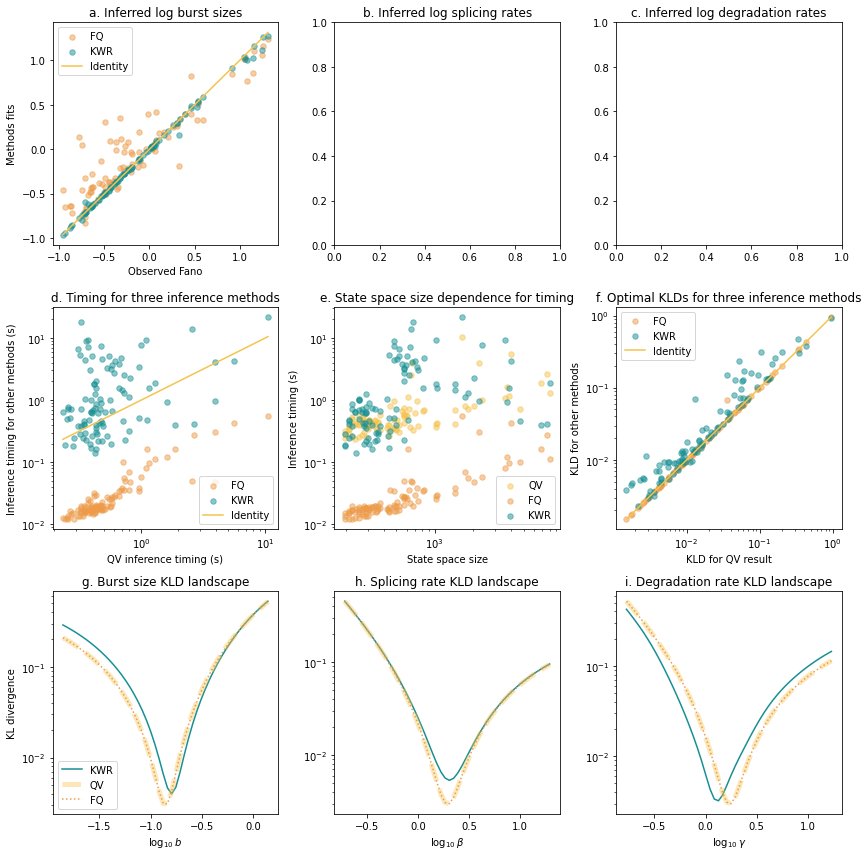

In [120]:
fig1,ax1=plt.subplots(3,3,figsize=(12,12))

# for k in range(3):
#     ax1[0,k].scatter(pars_qv[:,k],pars_fq[:,k],ms,color_fq,alpha=alf,label='FQ')
# #     ax1[0,k].scatter(pars_qv[:,k],pars_nn[:,k],ms,color_nn,alpha=alf,label='nnNB')
#     ax1[0,k].scatter(pars_qv[:,k],pars_nn10[:,k],ms,color_nn10,alpha=alf,label='KWR')
# #     ax1[0,k].scatter(pars_qv[:,k],pars_fq_hf[:,k],ms,color_fq_hf,alpha=alf,label='FQpad')
#     xl = [pars_qv[:,k].min(),pars_qv[:,k].max()]
#     ax1[0,k].plot(xl,xl,'-',color=color_qv,label='Identity')
#     ax1[0,k].set_xlabel('QV result')
#     ax1[0,k].set_ylabel('Result using other methods')
#     ax1[0,k].legend()

k=0 
lf = np.log10(fanos[0]-1)
# ax1[0,k].scatter(lf,pars_qv[:,k],ms,color_qv,alpha=alf,label='QV')
ax1[0,k].scatter(lf,pars_fq[:,k],ms,color_fq,alpha=alf,label='FQ')
# ax1[0,k].scatter(lf,pars_nn[:,k],ms,color_nn,alpha=alf,label='nnNB')
ax1[0,k].scatter(lf,pars_nn10[:,k],ms,color_nn10,alpha=alf,label='KWR')
# ax1[0,k].scatter(lf,np.log10(fanos[0]-1),ms,'k',alpha=alf,label='True')
xl = [lf.min(),lf.max()]
# ax1[0,k].scatter(pars_qv[:,k],pars_fq[:,k],ms,color_fq,alpha=alf,label='FQ')
# ax1[0,k].scatter(pars_qv[:,k],pars_nn10[:,k],ms,color_nn10,alpha=alf,label='KWR')
# ax1[0,k].scatter(pars_qv[:,k],np.log10(fanos[0]-1),ms,'k',alpha=alf,label='True')
# xl = [pars_qv[:,k].min(),pars_qv[:,k].max()]
ax1[0,k].plot(xl,xl,'-',color=color_qv,label='Identity')
ax1[0,k].set_xlabel('Observed Fano')
ax1[0,k].set_ylabel('Methods'' fits')
ax1[0,k].legend()
# k=0
# ax1[0,k].scatter(pars_qv[:,0]-pars_qv[:,1],pars_fq[:,0]-pars_fq[:,1],ms,color_fq,alpha=alf,label='FQ')
# ax1[0,k].scatter(pars_qv[:,0]-pars_qv[:,1],pars_nn10[:,0]-pars_nn10[:,1],ms,color_nn10,alpha=alf,label='KWR')
# ax1[0,k].scatter(pars_qv[:,0]-pars_qv[:,1],np.log10(means[0]),ms,'k',alpha=alf,label='True')
# xl = [(pars_qv[:,0]-pars_qv[:,1]).min(),(pars_qv[:,0]-pars_qv[:,1]).max()]
# ax1[0,k].plot(xl,xl,'-',color=color_qv,label='Identity')
# ax1[0,k].set_xlabel('QV nas mean')
# ax1[0,k].set_ylabel('Result using other methods')
# ax1[0,k].legend()

# k=1
# ax1[0,k].scatter(pars_qv[:,0]-pars_qv[:,2],pars_fq[:,0]-pars_fq[:,2],ms,color_fq,alpha=alf,label='FQ')
# ax1[0,k].scatter(pars_qv[:,0]-pars_qv[:,2],pars_nn10[:,0]-pars_nn10[:,2],ms,color_nn10,alpha=alf,label='KWR')
# ax1[0,k].scatter(pars_qv[:,0]-pars_qv[:,2],np.log10(means[1]),ms,'k',alpha=alf,label='True')
# xl = [(pars_qv[:,0]-pars_qv[:,2]).min(),(pars_qv[:,0]-pars_qv[:,2]).max()]
# ax1[0,k].plot(xl,xl,'-',color=color_qv,label='Identity')
# ax1[0,k].set_xlabel('QV mat mean')
# ax1[0,k].set_ylabel('Result using other methods')
# ax1[0,k].legend()
    
ax1[1,0].scatter(t_qv,t_fq,ms,color_fq,alpha=alf,label='FQ')
# ax1[1,0].scatter(t_qv,t_nn,ms,color_nn,alpha=alf,label='nnNB')
ax1[1,0].scatter(t_qv,t_nn10,ms,color_nn10,alpha=alf,label='KWR')
xl = [t_qv.min(),t_qv.max()]
ax1[1,0].plot(xl,xl,'-',color=color_qv,label='Identity')
ax1[1,0].set_xscale('log')
ax1[1,0].set_yscale('log')
ax1[1,0].set_xlabel('QV inference timing (s)')
ax1[1,0].set_ylabel('Inference timing for other methods (s)')
ax1[1,0].legend()

ss = search_data.M.prod(0)[:N]
ax1[1,1].scatter(ss,t_qv,ms,color_qv,alpha=alf,label='QV')
ax1[1,1].scatter(ss,t_fq,ms,color_fq,alpha=alf,label='FQ')
# ax1[1,1].scatter(ss,t_nn,ms,color_nn,alpha=alf,label='nnNB')
ax1[1,1].scatter(ss,t_nn10,ms,color_nn10,alpha=alf,label='KWR')
ax1[1,1].set_xscale('log')
ax1[1,1].set_yscale('log')
ax1[1,1].set_xlabel('State space size')
ax1[1,1].set_ylabel('Inference timing (s)')
ax1[1,1].legend()

ax1[1,2].scatter(loss_qv,loss_fq,ms,color_fq,alpha=alf,label='FQ')
# ax1[1,2].scatter(loss_qv,loss_nn,ms,color_nn,alpha=alf,label='nnNB')
ax1[1,2].scatter(loss_qv,loss_nn10,ms,color_nn10,alpha=alf,label='KWR')
xl = [loss_qv.min(),loss_qv.max()]
ax1[1,2].plot(xl,xl,'-',color=color_qv,label='Identity')
ax1[1,2].set_xscale('log')
ax1[1,2].set_yscale('log')
ax1[1,2].legend()
ax1[1,2].set_xlabel('KLD for QV result')
ax1[1,2].set_ylabel('KLD for other methods')

gind = 1
param_names = fitmodel_nn.get_log_name_str()
n_pts = 50
for k in range(3):
    p = pars_nn[gind]
    domain = p[k] + np.linspace(-1,1,n_pts)
    kld_nn = []
    kld_nn10 = []
    kld_fq = []
    kld_qv = []
    for d in domain:
        p_ = np.copy(p)
        p_[k] = d
        
        kld_nn.append(fitmodel_nn.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))
        kld_nn10.append(fitmodel_nn10.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))
        kld_qv.append(fitmodel_qv.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))
        kld_fq.append(fitmodel_fq.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))
#     ax1[2,k].plot(domain,kld_nn,'-',color=color_nn,label='nnNB')
    ax1[2,k].plot(domain,kld_nn10,'-',color=color_nn10,label='KWR')
    ax1[2,k].plot(domain,kld_qv,'--',color=color_qv,linewidth=5,alpha=0.4,label='QV')
    ax1[2,k].plot(domain,kld_fq,':',color=color_fq,alpha=1,label='FQ')
    ax1[2,k].set_xlabel(param_names[k])
    ax1[2,k].set_yscale('log')
    if k==0:
        ax1[2,k].legend()
        ax1[2,k].set_ylabel('KL divergence')

# ax1[0,0].set_title('a. Inferred log burst sizes')
ax1[0,0].set_title('a. Inferred log burst sizes')
ax1[0,1].set_title('b. Inferred log splicing rates')
ax1[0,2].set_title('c. Inferred log degradation rates')
ax1[1,0].set_title('d. Timing for three inference methods')
ax1[1,1].set_title('e. State space size dependence for timing')
ax1[1,2].set_title('f. Optimal KLDs for three inference methods')
ax1[2,0].set_title('g. Burst size KLD landscape')
ax1[2,1].set_title('h. Splicing rate KLD landscape')
ax1[2,2].set_title('i. Degradation rate KLD landscape')

plt.tight_layout()
# plt.savefig('./figs/monod.png',dpi=450)
# plt.savefig('./figs/monod.pdf')


In [41]:
# np.subtract(loss_qv,loss_fq).sum()

In [36]:
# %lprun -f fitmodel_nn.eval_model_kld [grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data) for i in range(3)]

In [37]:
# %lprun -f monod.nn_toolbox.get_ypred_log_1NB  [grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data) for i in range(3)]